# Proyecto Redes Neuronales: Transformer Encoder (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo Transformer Encoder usando PyTorch  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## 0. Configuracion de Parametros Globales

In [ ]:
# Configuracion del experimento
from datetime import datetime as dt
EXPERIMENT_TIMESTAMP = dt.now().strftime("%Y%m%d_%H%M%S")

EXPERIMENT_NAME = "Transformer_PyTorch_GloVe_Frozen"
MODEL_TYPE = "Transformer_Torch_GloVe_Frozen"
MODEL_SAVE_NAME = f"{MODEL_TYPE}_{EXPERIMENT_TIMESTAMP}"
RANDOM_SEED = 42
PROJECT_PART = "project_part_4"

# Directorios
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"
GLOVE_PATH = "data/glove/glove.6B.200d.txt" 

# Dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"
USE_TITLE_AND_BODY = True

# Tokenizacion
MAX_VOCAB_SIZE = 50000
MAX_LENGTH = 200

# Arquitectura del Transformer 
EMBEDDING_DIM = 200  
NUM_HEADS = 4  
NUM_LAYERS = 4  
DIM_FEEDFORWARD = 800  
DROPOUT_RATE = 0.1
POOLING = 'cls'  
USE_PRETRAINED_EMBEDDINGS = True
FREEZE_EMBEDDINGS = True 

# Entrenamiento (Parametros propuestos)
EPOCHS = 50
BATCH_SIZE = 32  # Como propuesta
LEARNING_RATE = 1e-4  # LR alto (seguro con embeddings congelados)
PATIENCE = 7  # Paciencia moderada-alta
WEIGHT_DECAY = 1e-4  # Regularizacion ligera
CLIP_GRAD_NORM = 1.0
USE_CLASS_WEIGHTS = True
WARMUP_STEPS = 1000  # Warmup como propuesta

print(f"=== Configuracion: {EXPERIMENT_NAME} ===")
print(f"Nombre del modelo: {MODEL_SAVE_NAME}")
print(f"Arquitectura: D={EMBEDDING_DIM}, Heads={NUM_HEADS}, Layers={NUM_LAYERS}, FF={DIM_FEEDFORWARD}")
print(f"Embeddings: GloVe 200d CONGELADOS (protegidos)")
print(f"Pooling: {POOLING} (cls token como modelo exitoso)")
print(f"Entrenamiento: LR={LEARNING_RATE} (alto, seguro con freeze), Batch={BATCH_SIZE}")
print(f"Estrategia: Embeddings fijos + Transformer ligero + LR alto")
print(f"GPU: RTX 5070 12GB")
print("="*60)


=== Configuracion: Transformer_PyTorch_GloVe_Frozen ===
Nombre del modelo: Transformer_Torch_GloVe_Frozen_20251130_154132
Arquitectura: D=200, Heads=4, Layers=4, FF=800
Embeddings: GloVe 200d CONGELADOS (protegidos)
Pooling: cls (cls token como modelo exitoso)
Entrenamiento: LR=0.0001 (alto, seguro con freeze), Batch=32
Estrategia: Embeddings fijos + Transformer ligero + LR alto
GPU: RTX 5070 12GB


## 1. Importacion de Librerias

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import TransformerClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070


## 2. Carga y Preprocesamiento de Datos

In [3]:
print("=== Cargando datos ===")

# Inicializar DataLoader
data_loader = DataLoaderTorch(data_dir=DATA_DIR)

# Cargar datasets
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nTamanos de conjuntos:")
print(f"  Entrenamiento: {len(train_df):,}")
print(f"  Validacion: {len(val_df):,}")
print(f"  Prueba: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE:
    if LANGUAGE_COLUMN in train_df.columns:
        print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
        train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        print(f"Tamanos despues de filtrar:")
        print(f"  Entrenamiento: {len(train_df):,}")
        print(f"  Validacion: {len(val_df):,}")
        print(f"  Prueba: {len(test_df):,}")

# Verificar distribucion de clases
if TARGET_COLUMN in train_df.columns:
    print(f"\nDistribucion de clases (entrenamiento):")
    for i in range(1, 6):
        count = len(train_df[train_df[TARGET_COLUMN] == i])
        print(f"  Clase {i} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

=== Cargando datos ===
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamanos de conjuntos:
  Entrenamiento: 1,200,000
  Validacion: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamanos de conjuntos:
  Entrenamiento: 1,200,000
  Validacion: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Tamanos despues de filtrar:
  Entrenamiento: 200,000
  Validacion: 5,000
  Prueba: 5,000

Distribucion de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20.0%)
  Clase 3 estrellas: 40,000 (20.0%)
  Clase 4 estrellas: 40,000 (20.0%)
  Clase 5 estrellas: 40,000 (20.0%)
Tamanos despues de filtrar:
  Entrenamiento: 200,000
  Validacion: 5,000
  Prueba: 5,000

Distribucion de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20

## 3. Preprocesamiento y Creacion de DataLoaders

Esta celda realiza:
- Tokenizacion de textos
- Construccion de vocabulario
- Conversion a secuencias numericas
- Padding de secuencias
- Creacion de DataLoaders de PyTorch

In [4]:
print("=== Preprocesando datos para embeddings ===")

# Preprocesar datos usando el metodo de embedding
preprocessing_result = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer resultados
train_loader = preprocessing_result['train_loader']
val_loader = preprocessing_result['val_loader']
test_loader = preprocessing_result['test_loader']
num_classes = preprocessing_result['num_classes']
vocab_size = preprocessing_result['vocab_size']
pad_idx = 0  # Keras siempre usa 0 como padding index

print(f"\nVocabulario construido:")
print(f"  Tamano del vocabulario: {vocab_size:,}")
print(f"  Indice de padding: {pad_idx}")
print(f"  Numero de clases: {num_classes}")
print(f"  Max length: {MAX_LENGTH}")

print(f"\nDataLoaders creados:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Ejemplo de un batch
sample_batch = next(iter(train_loader))
print(f"\nEjemplo de batch:")
print(f"  Forma de secuencias: {sample_batch[0].shape}")
print(f"  Forma de labels: {sample_batch[1].shape}")

=== Preprocesando datos para embeddings ===
Preprocesando datos de texto...
Ajustando tokenizer solo con datos de entrenamiento (evitando data leakage)...
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 200
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamano del vocabulario: 48,283
  Indice de padding: 0
  Numero de clases: 5
  Max length: 200

DataLoaders creados:
  Train batches: 6250
  Val batches: 157
  Test batches: 157

Ejemplo de batch:
  Forma de secuencias: torch.Size([32, 200])
  Forma de labels: torch.Size([32])
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 200
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamano del vocabulario: 48,2

## 4. Construccion del Modelo Transformer

**Estrategia con Embeddings GloVe Congelados:**

Esta configuración usa una estrategia inteligente para aprovechar GloVe sin degradar su calidad:

### Ventajas del FREEZE_EMBEDDINGS=True:

1. **Protección de conocimiento**: Los embeddings GloVe mantienen sus relaciones semánticas originales
2. **LR alto seguro**: Podemos usar learning rate más alto (1e-4) sin destruir los embeddings
3. **Convergencia rápida**: El Transformer aprende sobre representaciones fijas y de calidad
4. **Menos parámetros**: Reduce parámetros entrenables, menos riesgo de overfitting

### Arquitectura Ligera:
- **4 layers**: Suficiente profundidad sin complejidad excesiva
- **4 heads**: División perfecta de 200d (50 dim/head)
- **cls pooling**: Probado exitoso en experimentos anteriores

### Hipótesis:
GloVe congelado + Transformer ligero + LR alto = **convergencia rápida y generalización robusta**


In [5]:
print("=== Construyendo modelo Transformer Encoder ===")

# Verificar que EMBEDDING_DIM sea divisible por NUM_HEADS
assert EMBEDDING_DIM % NUM_HEADS == 0, f"EMBEDDING_DIM ({EMBEDDING_DIM}) debe ser divisible por NUM_HEADS ({NUM_HEADS})"

# Crear modelo
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    num_classes=num_classes,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout_rate=DROPOUT_RATE,
    max_length=MAX_LENGTH,
    padding_idx=pad_idx,
    pooling=POOLING
)

print(f"\nArquitectura del modelo:")
print(model)

# Contar parametros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParametros totales: {total_params:,}")
print(f"Parametros entrenables: {trainable_params:,}")

# Cargar embeddings preentrenados GloVe si esta habilitado
if USE_PRETRAINED_EMBEDDINGS:
    print(f"\n=== Cargando embeddings GloVe preentrenados ===")
    print(f"Archivo: {GLOVE_PATH}")
    
    import numpy as np
    
    # Cargar GloVe
    embeddings_index = {}
    with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f"GloVe cargado: {len(embeddings_index):,} palabras")
    
    # Crear matriz de embeddings
    embedding_matrix = np.zeros((vocab_size + 1, EMBEDDING_DIM))  # +1 para CLS token
    words_found = 0
    
    # Obtener word_index del tokenizer
    word_index = data_loader.tokenizer.word_index
    
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_found += 1
        else:
            # Inicializar palabras no encontradas con valores aleatorios pequeños
            embedding_matrix[i] = np.random.normal(0, 0.05, EMBEDDING_DIM)
    
    # Token CLS inicializado aleatoriamente
    embedding_matrix[vocab_size] = np.random.normal(0, 0.05, EMBEDDING_DIM)
    
    print(f"Palabras encontradas en GloVe: {words_found:,}/{len(word_index):,} ({words_found/len(word_index)*100:.1f}%)")
    
    # Cargar embeddings en el modelo
    model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    
    # Congelar embeddings si se especifica
    if FREEZE_EMBEDDINGS:
        model.embedding.weight.requires_grad = False
        print("Embeddings congelados (no se entrenarán)")
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Parametros entrenables actualizados: {trainable_params:,}")
    else:
        print("Embeddings se fine-tunearan durante el entrenamiento")


=== Construyendo modelo Transformer Encoder ===

Arquitectura del modelo:
TransformerClassifier(
  (embedding): Embedding(48284, 200, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=800, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=800, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((200,), eps=1e-05, ele

## 5. Configuracion del Entrenamiento

In [6]:
print("=== Configurando entrenamiento ===")

# Calcular class weights para manejar desbalanceo
y_train_np = preprocessing_result['y_train'].numpy()
class_counts = np.bincount(y_train_np)
total_samples = len(y_train_np)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights) if USE_CLASS_WEIGHTS else None

print(f"Distribucion de clases:")
for i, count in enumerate(class_counts):
    weight_str = f"weight: {class_weights[i]:.4f}" if USE_CLASS_WEIGHTS else "weight: 1.0"
    print(f"  Clase {i+1}: {count:,} muestras, {weight_str}")

# Funcion de perdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None
)

# Optimizador AdamW (mejor para Transformers)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Scheduler con warmup
total_steps = len(train_loader) * EPOCHS

def lr_lambda(current_step):
    if current_step < WARMUP_STEPS:
        return float(current_step) / float(max(1, WARMUP_STEPS))
    return max(0.1, float(total_steps - current_step) / float(max(1, total_steps - WARMUP_STEPS)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"\nOptimizador: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: Linear warmup ({WARMUP_STEPS} steps) + Linear decay")
print(f"Total steps: {total_steps}")

=== Configurando entrenamiento ===
Distribucion de clases:
  Clase 1: 40,000 muestras, weight: 1.0000
  Clase 2: 40,000 muestras, weight: 1.0000
  Clase 3: 40,000 muestras, weight: 1.0000
  Clase 4: 40,000 muestras, weight: 1.0000
  Clase 5: 40,000 muestras, weight: 1.0000

Optimizador: AdamW (lr=0.0001, weight_decay=0.0001)
Scheduler: Linear warmup (1000 steps) + Linear decay
Total steps: 312500

Optimizador: AdamW (lr=0.0001, weight_decay=0.0001)
Scheduler: Linear warmup (1000 steps) + Linear decay
Total steps: 312500


## 6. Entrenamiento del Modelo

In [7]:
print("=== Iniciando entrenamiento ===")

# Inicializar trainer
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

# Entrenar modelo con nombre unico
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=MODEL_SAVE_NAME,
    scheduler=scheduler,
    clip_grad_norm=CLIP_GRAD_NORM,
    verbose=True
)

print(f"\n=== Entrenamiento completado ===")
print(f"Epocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo total: {training_results['training_time']:.2f}s")
print(f"Mejor Val Loss: {training_results['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {training_results['best_val_accuracy']:.4f}")

=== Iniciando entrenamiento ===
Usando dispositivo: cuda

Entrenando Transformer_Torch_GloVe_Frozen_20251130_154132...
Parámetros totales: 11,588,605
Parámetros entrenables: 1,931,805
Gradient clipping activado: max_norm=1.0


Epoch 1/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 207.84it/s, loss=2.0482, acc=20.06%]




Epoch 1/50:
  Train Loss: 2.0048, Train Acc: 0.2007, Train F1-Macro: 0.1429
  Val Loss: 1.8941, Val Acc: 0.2006, Val F1-Macro: 0.0806
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.0806)


Epoch 2/50 [Train]: 100%|██████████| 6250/6250 [01:28<00:00, 70.34it/s, loss=1.7546, acc=20.87%]

Epoch 2/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 214.85it/s, loss=1.3789, acc=23.28%]



Epoch 2/50:
  Train Loss: 1.8048, Train Acc: 0.2087, Train F1-Macro: 0.2076
  Val Loss: 1.6195, Val Acc: 0.2328, Val F1-Macro: 0.2212
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.2212)


Epoch 3/50 [Train]: 100%|██████████| 6250/6250 [01:28<00:00, 70.45it/s, loss=1.7777, acc=23.32%]

Epoch 3/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 216.09it/s, loss=1.1830, acc=29.74%]



Epoch 3/50:
  Train Loss: 1.7192, Train Acc: 0.2332, Train F1-Macro: 0.2327
  Val Loss: 1.5453, Val Acc: 0.2974, Val F1-Macro: 0.2897
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.2897)


Epoch 4/50 [Train]: 100%|██████████| 6250/6250 [01:28<00:00, 70.47it/s, loss=1.6759, acc=26.95%]

Epoch 4/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 206.56it/s, loss=0.9896, acc=35.56%]




Epoch 4/50:
  Train Loss: 1.6371, Train Acc: 0.2695, Train F1-Macro: 0.2679
  Val Loss: 1.4679, Val Acc: 0.3556, Val F1-Macro: 0.3409
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.3409)


Epoch 5/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 70.13it/s, loss=1.6580, acc=30.80%]

Epoch 5/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 202.15it/s, loss=0.8396, acc=39.56%]



Epoch 5/50:
  Train Loss: 1.5529, Train Acc: 0.3080, Train F1-Macro: 0.3047
  Val Loss: 1.3920, Val Acc: 0.3956, Val F1-Macro: 0.3792
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.3792)


Epoch 6/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.76it/s, loss=1.7045, acc=34.41%]

Epoch 6/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 196.56it/s, loss=0.7074, acc=41.62%]



Epoch 6/50:
  Train Loss: 1.4773, Train Acc: 0.3441, Train F1-Macro: 0.3394
  Val Loss: 1.3325, Val Acc: 0.4162, Val F1-Macro: 0.4000
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4000)


Epoch 7/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 70.05it/s, loss=1.3472, acc=37.50%]

Epoch 7/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 199.79it/s, loss=0.6411, acc=43.46%]



Epoch 7/50:
  Train Loss: 1.4131, Train Acc: 0.3750, Train F1-Macro: 0.3698
  Val Loss: 1.2897, Val Acc: 0.4346, Val F1-Macro: 0.4201
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4201)


Epoch 8/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 70.02it/s, loss=1.2172, acc=39.62%]

Epoch 8/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 198.92it/s, loss=0.6387, acc=44.88%]




Epoch 8/50:
  Train Loss: 1.3633, Train Acc: 0.3962, Train F1-Macro: 0.3912
  Val Loss: 1.2478, Val Acc: 0.4488, Val F1-Macro: 0.4385
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4385)


Epoch 9/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.55it/s, loss=1.2615, acc=41.57%]

Epoch 9/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 183.80it/s, loss=0.6246, acc=46.10%]



Epoch 9/50:
  Train Loss: 1.3211, Train Acc: 0.4157, Train F1-Macro: 0.4106
  Val Loss: 1.2154, Val Acc: 0.4610, Val F1-Macro: 0.4474
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4474)


Epoch 10/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.59it/s, loss=1.2055, acc=43.44%]

Epoch 10/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 197.28it/s, loss=0.6100, acc=47.42%]



Epoch 10/50:
  Train Loss: 1.2815, Train Acc: 0.4344, Train F1-Macro: 0.4294
  Val Loss: 1.1880, Val Acc: 0.4742, Val F1-Macro: 0.4611
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4611)


Epoch 11/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 201.92it/s, loss=0.5967, acc=48.58%]



Epoch 11/50:
  Train Loss: 1.2509, Train Acc: 0.4473, Train F1-Macro: 0.4424
  Val Loss: 1.1655, Val Acc: 0.4858, Val F1-Macro: 0.4784
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4784)


Epoch 12/50 [Train]: 100%|██████████| 6250/6250 [01:32<00:00, 67.83it/s, loss=1.3558, acc=45.73%]

Epoch 12/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 211.17it/s, loss=0.5834, acc=49.30%]



Epoch 12/50:
  Train Loss: 1.2270, Train Acc: 0.4573, Train F1-Macro: 0.4526
  Val Loss: 1.1500, Val Acc: 0.4930, Val F1-Macro: 0.4807
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4807)


Epoch 13/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 207.17it/s, loss=0.6293, acc=50.46%]



Epoch 13/50:
  Train Loss: 1.2055, Train Acc: 0.4687, Train F1-Macro: 0.4640
  Val Loss: 1.1337, Val Acc: 0.5046, Val F1-Macro: 0.4987
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4987)


Epoch 14/50 [Train]: 100%|██████████| 6250/6250 [01:31<00:00, 68.01it/s, loss=1.2771, acc=47.56%]

Epoch 14/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 207.57it/s, loss=0.6165, acc=51.30%]



Epoch 14/50:
  Train Loss: 1.1879, Train Acc: 0.4756, Train F1-Macro: 0.4711
  Val Loss: 1.1203, Val Acc: 0.5130, Val F1-Macro: 0.5052
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5052)


Epoch 15/50 [Train]: 100%|██████████| 6250/6250 [01:31<00:00, 68.22it/s, loss=1.3352, acc=48.55%]

Epoch 15/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 213.10it/s, loss=0.5751, acc=51.72%]



Epoch 15/50:
  Train Loss: 1.1726, Train Acc: 0.4855, Train F1-Macro: 0.4809
  Val Loss: 1.1084, Val Acc: 0.5172, Val F1-Macro: 0.5060
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5060)


Epoch 16/50 [Train]: 100%|██████████| 6250/6250 [01:31<00:00, 68.10it/s, loss=1.0130, acc=49.26%]

Epoch 16/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 204.02it/s, loss=0.6077, acc=52.68%]



Epoch 16/50:
  Train Loss: 1.1559, Train Acc: 0.4926, Train F1-Macro: 0.4883
  Val Loss: 1.0960, Val Acc: 0.5268, Val F1-Macro: 0.5179
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5179)


Epoch 17/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 212.72it/s, loss=0.6179, acc=53.12%]



Epoch 17/50:
  Train Loss: 1.1402, Train Acc: 0.5009, Train F1-Macro: 0.4967
  Val Loss: 1.0791, Val Acc: 0.5312, Val F1-Macro: 0.5236
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5236)


Epoch 18/50 [Train]: 100%|██████████| 6250/6250 [01:31<00:00, 68.30it/s, loss=0.9851, acc=50.73%]

Epoch 18/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 207.83it/s, loss=0.6152, acc=53.84%]



Epoch 18/50:
  Train Loss: 1.1250, Train Acc: 0.5073, Train F1-Macro: 0.5029
  Val Loss: 1.0636, Val Acc: 0.5384, Val F1-Macro: 0.5304
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5304)


Epoch 19/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 204.90it/s, loss=0.6672, acc=54.72%]



Epoch 19/50:
  Train Loss: 1.1074, Train Acc: 0.5176, Train F1-Macro: 0.5134
  Val Loss: 1.0473, Val Acc: 0.5472, Val F1-Macro: 0.5427
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5427)


Epoch 20/50 [Train]: 100%|██████████| 6250/6250 [01:31<00:00, 68.56it/s, loss=1.3223, acc=52.63%]

Epoch 20/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 212.31it/s, loss=0.6132, acc=55.32%]



Epoch 20/50:
  Train Loss: 1.0906, Train Acc: 0.5263, Train F1-Macro: 0.5220
  Val Loss: 1.0326, Val Acc: 0.5532, Val F1-Macro: 0.5477
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5477)


Epoch 21/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 204.69it/s, loss=0.6316, acc=55.68%]



Epoch 21/50:
  Train Loss: 1.0779, Train Acc: 0.5306, Train F1-Macro: 0.5264
  Val Loss: 1.0215, Val Acc: 0.5568, Val F1-Macro: 0.5512
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5512)


Epoch 22/50 [Train]: 100%|██████████| 6250/6250 [01:31<00:00, 68.38it/s, loss=1.4019, acc=53.75%]

Epoch 22/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 211.06it/s, loss=0.6054, acc=55.48%]




Epoch 22/50:
  Train Loss: 1.0637, Train Acc: 0.5375, Train F1-Macro: 0.5332
  Val Loss: 1.0120, Val Acc: 0.5548, Val F1-Macro: 0.5485
  Learning Rate: 0.000002
  Épocas sin mejora: 1/7


Epoch 23/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.48it/s, loss=1.0504, acc=54.30%]

Epoch 23/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 217.44it/s, loss=0.5873, acc=55.36%]



Epoch 23/50:
  Train Loss: 1.0511, Train Acc: 0.5430, Train F1-Macro: 0.5388
  Val Loss: 1.0096, Val Acc: 0.5536, Val F1-Macro: 0.5436
  Learning Rate: 0.000002
  Épocas sin mejora: 2/7


Epoch 24/50 [Train]: 100%|██████████| 6250/6250 [01:30<00:00, 69.24it/s, loss=1.1951, acc=54.74%]

Epoch 24/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 217.05it/s, loss=0.6520, acc=56.08%]



Epoch 24/50:
  Train Loss: 1.0433, Train Acc: 0.5474, Train F1-Macro: 0.5434
  Val Loss: 1.0032, Val Acc: 0.5608, Val F1-Macro: 0.5561
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5561)


Epoch 25/50 [Train]: 100%|██████████| 6250/6250 [01:30<00:00, 69.39it/s, loss=0.9049, acc=54.92%]

Epoch 25/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 221.51it/s, loss=0.6342, acc=56.56%]




Epoch 25/50:
  Train Loss: 1.0352, Train Acc: 0.5492, Train F1-Macro: 0.5451
  Val Loss: 0.9995, Val Acc: 0.5656, Val F1-Macro: 0.5603
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5603)


Epoch 26/50 [Train]: 100%|██████████| 6250/6250 [01:28<00:00, 70.28it/s, loss=1.0253, acc=55.26%]

Epoch 26/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 216.43it/s, loss=0.6498, acc=56.36%]



Epoch 26/50:
  Train Loss: 1.0280, Train Acc: 0.5526, Train F1-Macro: 0.5485
  Val Loss: 0.9965, Val Acc: 0.5636, Val F1-Macro: 0.5560
  Learning Rate: 0.000003
  Épocas sin mejora: 1/7


Epoch 27/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 217.95it/s, loss=0.6683, acc=56.82%]



Epoch 27/50:
  Train Loss: 1.0217, Train Acc: 0.5546, Train F1-Macro: 0.5505
  Val Loss: 0.9911, Val Acc: 0.5682, Val F1-Macro: 0.5627
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5627)


Epoch 28/50 [Train]: 100%|██████████| 6250/6250 [01:28<00:00, 70.53it/s, loss=0.9228, acc=55.75%]

Epoch 28/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 218.00it/s, loss=0.6520, acc=57.12%]



Epoch 28/50:
  Train Loss: 1.0159, Train Acc: 0.5575, Train F1-Macro: 0.5536
  Val Loss: 0.9879, Val Acc: 0.5712, Val F1-Macro: 0.5647
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5647)


Epoch 29/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 219.77it/s, loss=0.6236, acc=57.92%]



Epoch 29/50:
  Train Loss: 1.0089, Train Acc: 0.5615, Train F1-Macro: 0.5576
  Val Loss: 0.9810, Val Acc: 0.5792, Val F1-Macro: 0.5723
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5723)


Epoch 30/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.60it/s, loss=1.1319, acc=56.43%]

Epoch 30/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 221.16it/s, loss=0.6465, acc=57.74%]



Epoch 30/50:
  Train Loss: 1.0042, Train Acc: 0.5643, Train F1-Macro: 0.5604
  Val Loss: 0.9757, Val Acc: 0.5774, Val F1-Macro: 0.5735
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5735)


Epoch 31/50 [Train]: 100%|██████████| 6250/6250 [01:30<00:00, 69.40it/s, loss=0.9190, acc=56.56%]

Epoch 31/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 215.85it/s, loss=0.6828, acc=57.72%]



Epoch 31/50:
  Train Loss: 0.9985, Train Acc: 0.5656, Train F1-Macro: 0.5618
  Val Loss: 0.9751, Val Acc: 0.5772, Val F1-Macro: 0.5727
  Learning Rate: 0.000003
  Épocas sin mejora: 1/7


Epoch 32/50 [Train]: 100%|██████████| 6250/6250 [01:30<00:00, 69.23it/s, loss=1.1153, acc=56.80%]

Epoch 32/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 219.54it/s, loss=0.6828, acc=57.80%]



Epoch 32/50:
  Train Loss: 0.9925, Train Acc: 0.5681, Train F1-Macro: 0.5641
  Val Loss: 0.9708, Val Acc: 0.5780, Val F1-Macro: 0.5730
  Learning Rate: 0.000003
  Épocas sin mejora: 2/7


Epoch 33/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 215.14it/s, loss=0.6597, acc=58.24%]




Epoch 33/50:
  Train Loss: 0.9871, Train Acc: 0.5709, Train F1-Macro: 0.5672
  Val Loss: 0.9661, Val Acc: 0.5824, Val F1-Macro: 0.5791
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5791)


Epoch 34/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 212.02it/s, loss=0.5821, acc=58.20%]



Epoch 34/50:
  Train Loss: 0.9845, Train Acc: 0.5724, Train F1-Macro: 0.5687
  Val Loss: 0.9645, Val Acc: 0.5820, Val F1-Macro: 0.5758
  Learning Rate: 0.000003
  Épocas sin mejora: 1/7


Epoch 35/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 208.99it/s, loss=0.6580, acc=58.48%]



Epoch 35/50:
  Train Loss: 0.9802, Train Acc: 0.5740, Train F1-Macro: 0.5702
  Val Loss: 0.9598, Val Acc: 0.5848, Val F1-Macro: 0.5814
  Learning Rate: 0.000004
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5814)


Epoch 36/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 211.13it/s, loss=0.6323, acc=58.48%]



Epoch 36/50:
  Train Loss: 0.9767, Train Acc: 0.5764, Train F1-Macro: 0.5728
  Val Loss: 0.9586, Val Acc: 0.5848, Val F1-Macro: 0.5803
  Learning Rate: 0.000004
  Épocas sin mejora: 1/7


Epoch 37/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.59it/s, loss=1.0390, acc=57.68%]

Epoch 37/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 229.05it/s, loss=0.6390, acc=58.26%]



Epoch 37/50:
  Train Loss: 0.9739, Train Acc: 0.5768, Train F1-Macro: 0.5732
  Val Loss: 0.9551, Val Acc: 0.5826, Val F1-Macro: 0.5776
  Learning Rate: 0.000004
  Épocas sin mejora: 2/7


Epoch 38/50 [Train]: 100%|██████████| 6250/6250 [01:27<00:00, 71.37it/s, loss=1.1297, acc=58.03%]

Epoch 38/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 227.69it/s, loss=0.6442, acc=58.38%]



Epoch 38/50:
  Train Loss: 0.9696, Train Acc: 0.5803, Train F1-Macro: 0.5766
  Val Loss: 0.9528, Val Acc: 0.5838, Val F1-Macro: 0.5794
  Learning Rate: 0.000004
  Épocas sin mejora: 3/7


Epoch 39/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 216.16it/s, loss=0.6445, acc=58.38%]



Epoch 39/50:
  Train Loss: 0.9672, Train Acc: 0.5799, Train F1-Macro: 0.5764
  Val Loss: 0.9520, Val Acc: 0.5838, Val F1-Macro: 0.5767
  Learning Rate: 0.000004
  Épocas sin mejora: 4/7


Epoch 40/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 215.10it/s, loss=0.7025, acc=58.76%]



Epoch 40/50:
  Train Loss: 0.9632, Train Acc: 0.5814, Train F1-Macro: 0.5779
  Val Loss: 0.9496, Val Acc: 0.5876, Val F1-Macro: 0.5858
  Learning Rate: 0.000004
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5858)


Epoch 41/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 214.67it/s, loss=0.6363, acc=58.22%]



Epoch 41/50:
  Train Loss: 0.9620, Train Acc: 0.5832, Train F1-Macro: 0.5796
  Val Loss: 0.9507, Val Acc: 0.5822, Val F1-Macro: 0.5749
  Learning Rate: 0.000004
  Épocas sin mejora: 1/7


Epoch 42/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 69.76it/s, loss=0.9789, acc=58.60%]

Epoch 42/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 213.61it/s, loss=0.7316, acc=59.02%]



Epoch 42/50:
  Train Loss: 0.9583, Train Acc: 0.5860, Train F1-Macro: 0.5826
  Val Loss: 0.9466, Val Acc: 0.5902, Val F1-Macro: 0.5866
  Learning Rate: 0.000004
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5866)


Epoch 43/50 [Train]: 100%|██████████| 6250/6250 [01:29<00:00, 70.02it/s, loss=0.8006, acc=58.45%]

Epoch 43/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 219.27it/s, loss=0.6455, acc=58.72%]



Epoch 43/50:
  Train Loss: 0.9565, Train Acc: 0.5845, Train F1-Macro: 0.5809
  Val Loss: 0.9488, Val Acc: 0.5872, Val F1-Macro: 0.5780
  Learning Rate: 0.000004
  Épocas sin mejora: 1/7


Epoch 44/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 210.54it/s, loss=0.6110, acc=59.36%]



Epoch 44/50:
  Train Loss: 0.9541, Train Acc: 0.5865, Train F1-Macro: 0.5831
  Val Loss: 0.9425, Val Acc: 0.5936, Val F1-Macro: 0.5894
  Learning Rate: 0.000004
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5894)


Epoch 45/50 [Train]: 100%|██████████| 6250/6250 [01:30<00:00, 68.70it/s, loss=0.9476, acc=58.69%]

Epoch 45/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 212.30it/s, loss=0.6890, acc=58.56%]



Epoch 45/50:
  Train Loss: 0.9516, Train Acc: 0.5869, Train F1-Macro: 0.5835
  Val Loss: 0.9441, Val Acc: 0.5856, Val F1-Macro: 0.5793
  Learning Rate: 0.000005
  Épocas sin mejora: 1/7


Epoch 46/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 200.18it/s, loss=0.6494, acc=59.30%]



Epoch 46/50:
  Train Loss: 0.9492, Train Acc: 0.5893, Train F1-Macro: 0.5859
  Val Loss: 0.9414, Val Acc: 0.5930, Val F1-Macro: 0.5908
  Learning Rate: 0.000005
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5908)


Epoch 47/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 201.92it/s, loss=0.6129, acc=59.10%]



Epoch 47/50:
  Train Loss: 0.9462, Train Acc: 0.5902, Train F1-Macro: 0.5870
  Val Loss: 0.9384, Val Acc: 0.5910, Val F1-Macro: 0.5875
  Learning Rate: 0.000005
  Épocas sin mejora: 1/7


Epoch 48/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 209.37it/s, loss=0.5732, acc=59.30%]



Epoch 48/50:
  Train Loss: 0.9443, Train Acc: 0.5910, Train F1-Macro: 0.5876
  Val Loss: 0.9377, Val Acc: 0.5930, Val F1-Macro: 0.5888
  Learning Rate: 0.000005
  Épocas sin mejora: 2/7


Epoch 49/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 214.89it/s, loss=0.6413, acc=59.72%]



Epoch 49/50:
  Train Loss: 0.9441, Train Acc: 0.5913, Train F1-Macro: 0.5879
  Val Loss: 0.9343, Val Acc: 0.5972, Val F1-Macro: 0.5935
  Learning Rate: 0.000005
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5935)


Epoch 50/50 [Val]: 100%|██████████| 157/157 [00:00<00:00, 200.09it/s, loss=0.5975, acc=59.38%]



Epoch 50/50:
  Train Loss: 0.9405, Train Acc: 0.5924, Train F1-Macro: 0.5891
  Val Loss: 0.9343, Val Acc: 0.5938, Val F1-Macro: 0.5909
  Learning Rate: 0.000005
  Épocas sin mejora: 1/7

Mejor modelo restaurado
Modelo guardado en: models/project_part_4/Transformer_Torch_GloVe_Frozen_20251130_154132.pth

=== Entrenamiento completado ===
Epocas entrenadas: 50
Tiempo total: 4551.17s
Mejor Val Loss: 0.9343
Mejor Val Accuracy: 0.5972


## 7. Evaluacion en Conjunto de Prueba

In [8]:
print("=== Evaluando en conjunto de prueba ===")

# Evaluar modelo
test_results = trainer.evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion
)

print(f"\n=== Resultados en Test ===")
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.4f}")

# Reporte de clasificacion
print("\nReporte de clasificacion:")
print(classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1} estrellas" for i in range(num_classes)],
    digits=4
))

=== Evaluando en conjunto de prueba ===

Evaluando modelo en conjunto de prueba...


Evaluando: 100%|██████████| 157/157 [00:00<00:00, 250.54it/s]

Test Loss: 0.9435
Test Accuracy: 0.6002
Test F1-Macro: 0.5967

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.71      1000
           1       0.52      0.54      0.53      1000
           2       0.49      0.46      0.47      1000
           3       0.58      0.50      0.54      1000
           4       0.69      0.78      0.73      1000

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000


=== Resultados en Test ===
Test Loss: 0.9435
Test Accuracy: 0.6002

Reporte de clasificacion:
              precision    recall  f1-score   support

 1 estrellas     0.6936    0.7220    0.7075      1000
 2 estrellas     0.5167    0.5400    0.5281      1000
 3 estrellas     0.4930    0.4570    0.4743      1000
 4 estrellas     0.5808    0.5030    0.5391      1000
 5 estrellas     0.6949    0.7790    0.7346      1000

    

## 8. Visualizacion de Resultados

=== Generando visualizaciones ===
Gráfico de historial de entrenamiento guardado en: output/project_part_4/Transformer_Torch_GloVe_Frozen_history.png
Gráfico de historial de entrenamiento guardado en: output/project_part_4/Transformer_Torch_GloVe_Frozen_history.png


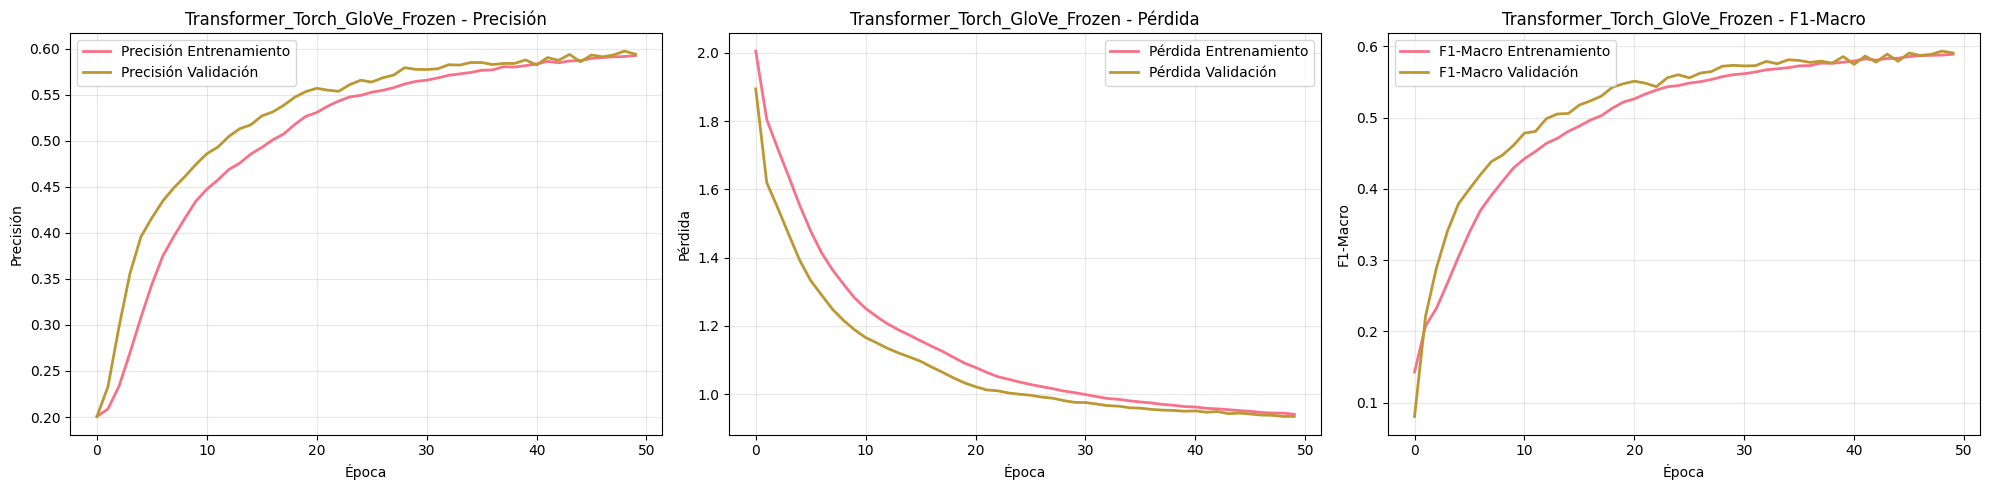

Matriz de confusión guardada en: output/project_part_4/Transformer_Torch_GloVe_Frozen_confusion_matrix.png


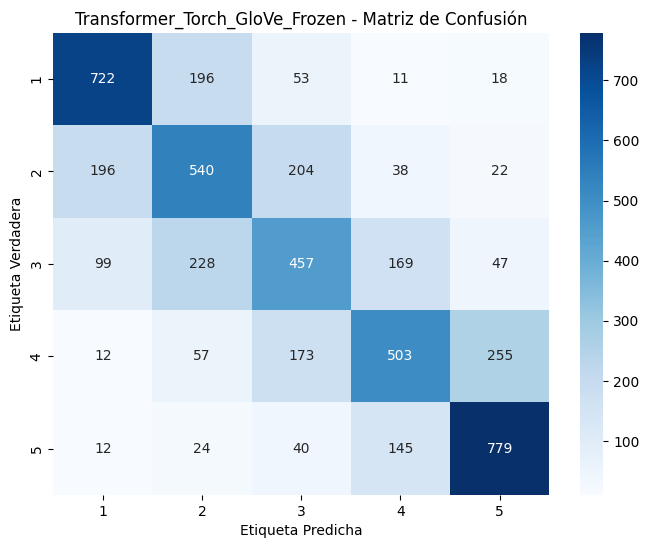

Visualizaciones guardadas en: output/project_part_4


In [9]:
print("=== Generando visualizaciones ===")

# Historia de entrenamiento
history = training_results['history']

# Graficar historia de entrenamiento (perdida y accuracy)
Visualizer.plot_training_history(
    history=history,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_history.png'),
    framework='pytorch'
)

# Matriz de confusion
Visualizer.plot_confusion_matrix(
    y_true=test_results['labels'],
    y_pred=test_results['predictions'],
    class_names=[f"{i+1}" for i in range(num_classes)],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_confusion_matrix.png')
)

print("Visualizaciones guardadas en:", OUTPUT_DIR)

## 9. Guardado de Resultados del Experimento

In [10]:
print("=== Guardando resultados del experimento ===")

# Reporte de clasificacion
from sklearn.metrics import classification_report as sklearn_classification_report
classification_rep = sklearn_classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1}" for i in range(num_classes)],
    output_dict=True
)

# Guardar componentes con nombre unico (tokenizer, label_encoder, etc)
save_model_components_torch(
    model_name=MODEL_SAVE_NAME,
    model=model,
    tokenizer=data_loader.tokenizer,
    label_encoder=data_loader.label_encoder,
    max_length=MAX_LENGTH,
    model_dir=MODEL_DIR
)

# Corregir model_path en training_results para que coincida con el nombre guardado
training_results['model_path'] = f"{MODEL_DIR}/{MODEL_SAVE_NAME}.pth"

# Preparar datos del experimento
experiment_data = {
    'experiment_name': f"{EXPERIMENT_NAME}_{EXPERIMENT_TIMESTAMP}",
    'configuration': {
        'model_type': MODEL_TYPE,
        'model_save_name': MODEL_SAVE_NAME,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'num_heads': NUM_HEADS,
        'num_layers': NUM_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD,
        'dropout_rate': DROPOUT_RATE,
        'pooling': POOLING,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'clip_grad_norm': CLIP_GRAD_NORM,
        'warmup_steps': WARMUP_STEPS,
        'patience': PATIENCE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'use_title_and_body': USE_TITLE_AND_BODY
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_results['test_accuracy'],
        'test_loss': test_results['test_loss'],
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar experimento
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Modelo guardado en: {MODEL_DIR}/{MODEL_SAVE_NAME}.pth")

=== Guardando resultados del experimento ===
Modelo guardado: models/project_part_4/Transformer_Torch_GloVe_Frozen_20251130_154132.pth
  - Configuración guardada: {'vocab_size': 48283, 'embedding_dim': 200, 'num_classes': 5, 'num_heads': 4, 'num_layers': 4, 'dim_feedforward': 800, 'dropout_rate': 0.1, 'max_length': 200, 'pooling': 'cls'}
Tokenizer guardado: models/project_part_4/Transformer_Torch_GloVe_Frozen_20251130_154132_tokenizer.pkl
Label encoder guardado: models/project_part_4/Transformer_Torch_GloVe_Frozen_20251130_154132_label_encoder.pkl
Componentes guardados en models/project_part_4/
Experiment 4 (Transformer_PyTorch_GloVe_Frozen_20251130_154132) saved to output/project_part_4/experiment_history.json

Experimento #4 guardado
Modelo guardado en: models/project_part_4/Transformer_Torch_GloVe_Frozen_20251130_154132.pth
